<!-- Include a figure with half of page width and located in center-->

![Source: Wikipedia](https://upload.wikimedia.org/wikipedia/commons/9/90/Physics-informed_nerural_networks.png)

## Introduction

Physics informed neural networks (PINNs) are a class of neural networks that are trained to leverage physics laws behind a system in addition to data to learn the system's behavior. Let's see a few scenarios where PINNs can be used:

1. Air quality inference at unknown locations using a few sensors at known locations. We can inform the neural network with the physics of diffusion and advection of pollutants.
2. Ground water modeling. We can inform the neural network with the physics of total water conservation.

In a nutshell, wherever we have a system that is governed by a set of partial differential equations (PDEs), we can use PINNs to learn the system's behavior.

## Comparison among PINNs, NNs and PDE Solvers
Here are the main differences among PINNs, Neural Networks (NNs) and PDE solvers:

| NNs | PDE solvers | PINNs |
| --- | --- | --- |
| Leverage only data | Leverage only physics | Leverage both data and physics |
| Accurate but may not be physically consistent | Not very accurate but physically consistent | Accurate and physically consistent |
| Require a lot of data | Require a lot of computational resources | Require less data and computational resources |

## Create a simple PINN
Let's say we have a system that is governed by the following PDE:
\begin{equation}
\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2}
\end{equation}
where $u$ is a function of $x$ and $t$. 

We can create a simple PINN to learn the behavior of $u(t, x)$ as a function of $t$ and $x$. 

* Inputs: $t$ and $x$
* Output: $u(t, x)$

Let's first import the required libraries:

In [25]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # specify which GPU(s) to be used

import warnings
warnings.filterwarnings("ignore")

from time import time
from functools import partial
import numpy as np
import pandas as pd

import jax
import jax.numpy as jnp

import optax
import jaxopt

import flax.linen as nn
import matplotlib.pyplot as plt

First, we generate some dummy data.

In [26]:
x_n = jnp.linspace(0, 1, 100).reshape(-1, 1)
t_n = jnp.linspace(0, 1, 100).reshape(-1, 1)
y_n = jax.random.uniform(jax.random.PRNGKey(0), (100, 1))


In [27]:
class SimplePINN(nn.Module):
    @nn.compact
    def __call__(self, t, x):
        x = jnp.concatenate([t, x], axis=-1)
        x = nn.Dense(8)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x.squeeze()


model = SimplePINN()


Consider `x_n` and `y_n` as training data. We can define the data-driven part of the loss function as follows:
$$
\mathcal{L}_{data} = \frac{1}{N}\sum_{i=1}^{N} (u_i - \hat{u}_i)^2
$$

In [28]:
def data_driven_loss_fn(params, t_n, x_n, y_n):
    pred_y_n = model.apply(params, t_n, x_n)
    return jnp.mean(jnp.square(y_n - pred_y_n))


Note that we can evaluate this loss function only at the training data points where ground truth is available. 

Now, we define the physics-informed part of the loss function as follows:
$$
\mathcal{L}_{physics} = \frac{1}{N}\sum_{i=1}^{N} \left(\frac{\partial \hat{u}_i}{\partial t} - \frac{\partial^2 \hat{u}_i}{\partial x^2}\right)^2
$$

In [29]:
def physics_informed_loss_fn(params, t_c, x_c):
    u_t = jax.grad(model.apply, argnums=1)(params, t_c, x_c)
    u_xx = jax.grad(model.apply, argnums=2)(params, t_c, x_c)

    return jnp.mean(jnp.square(u_t - u_xx))


Here, `argnums` is a keyword argument that specifies the argument number of the function `model.apply` with respect to which we want to take the gradient.

Note that we can evaluate this loss function at any arbitrary point in the domain. This is useful because we can use a large number of points to inform the neural network with the physics of the system and thus we can use a small number of data points to train the neural network. We will call these points as **collocation points**.

We can combine the above discussed losses and use any optimizer to learn the weights of the neural network. After that we can predict the value of $u(t, x)$ anywhere in the domain.

With this basic background, we can now classify PINNs into two categories:

1. Continuous time PINNs
2. Discrete time PINNs

## Continuous time PINNs
In this type of modeling, we learn the behavior of a system as a continuous function of time i.e. $u(t, x)$. Let's see a more realistic example of continuous time PINNs.

### Example: 1-D fluid flow with Burgers' equation
Burgers' equation is a nonlinear PDE that is used to model a variety of physical phenomena such as turbulence, shock waves, etc. It is given by:
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$
where $u$ is a function of $x$ and $t$ and $\nu$ is a constant.

In this demo, we will use it to model the behavior of a fluid in a pipe (one dimension). We will use the following boundary condition:

* At both ends of the pipe, the fluid velocity is zero.
$$
u(t, -1) = u(t, 1) = 0
$$

We will use the following initial condition:

* At $t=0$, the fluid velocity follows a negative Sine function.
$$
u(0, x) = -\sin(\pi x)
$$

Let's model this system using a continuous time PINN with the following configuration:

In [30]:
class Config:
    nu = 0.01/np.pi
    train_size = 100
    collocation_size = 10000
    neurons_per_layer = [2] + [20]*8 + [1]
    lr = 1e-3
    num_epochs = 10000
    activation_name = "tanh"


config = Config()

First, we will load the ground truth data generated from numerical simulation. We will use this data later to compare the performance of the PINN.

In [31]:
from scipy.io import loadmat

data = loadmat("burgers_shock.mat")
t_gt = data["t"].reshape(-1, 1)
x_gt = data["x"].reshape(-1, 1)
u_gt = data["usol"].T
print(t_gt.shape, x_gt.shape, u_gt.shape)

(100, 1) (256, 1) (100, 256)


Let's visualize the ground truth data.

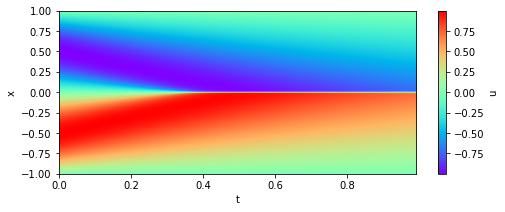

In [32]:
plt.figure(figsize=(8, 3))
img = plt.imshow(
    u_gt.T,
    aspect="auto",
    cmap="rainbow",
    origin="lower",
    extent=[t_gt.min(), t_gt.max(), x_gt.min(), x_gt.max()],
)
plt.xlabel("t")
plt.ylabel("x")
cb = plt.colorbar(img)
cb.set_label("u")

Now, we generate the training data. Half of the training data is generated from the initial condition:

In [33]:
t_ic = jnp.zeros((config.train_size // 2, 1))

x_ic_key = jax.random.PRNGKey(1234)
x_ic = jax.random.uniform(
    x_ic_key, (config.train_size // 2, 1), minval=-1, maxval=1
).reshape(-1, 1)

u_ic = -jnp.sin(jnp.pi * x_ic)
print(t_ic.shape, x_ic.shape, u_ic.shape)

(50, 1) (50, 1) (50, 1)


The other half of the training data is generated from the boundary condition:

In [34]:
t_bc_key = jax.random.PRNGKey(5678)
x_bc = jnp.vstack(
    [-jnp.ones((config.train_size // 4, 1)), jnp.ones((config.train_size // 4, 1))]
)
t_bc = jax.random.uniform(t_bc_key, (config.train_size // 2, 1))
u_bc = jnp.zeros_like(t_bc)
print(t_bc.shape, x_bc.shape, u_bc.shape)

(50, 1) (50, 1) (50, 1)


We can now combine and visualize the training data as follows:

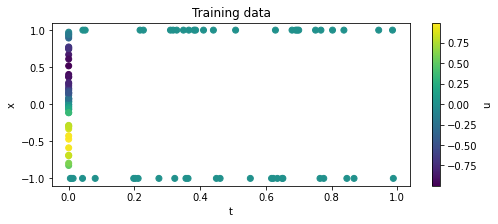

In [35]:
t_n = jnp.vstack([t_ic, t_bc])
x_n = jnp.vstack([x_ic, x_bc])
u_n = jnp.vstack([u_ic, u_bc])

plt.figure(figsize=(8, 3))
plt.scatter(t_n, x_n, c=u_n, cmap="viridis")
cb = plt.colorbar()
cb.set_label("u")
plt.xlabel("t")
plt.ylabel("x")
_ = plt.title("Training data")

Now, we generate the collocation points. We will generate them randomly in the domain.

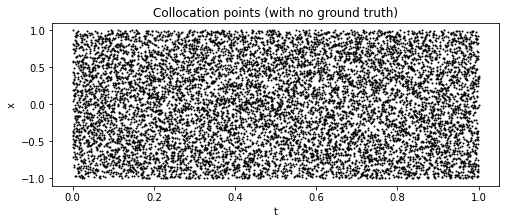

In [36]:
from pyDOE2.doe_lhs import lhs
from random import seed

lhs_points = lhs(2, config.collocation_size, random_state=0)
t_c = lhs_points[:, 0].reshape(-1, 1)
x_c = lhs_points[:, 1].reshape(-1, 1) * 2 - 1

plt.figure(figsize=(8, 3))
plt.scatter(t_c, x_c, c="k", s=1)
plt.xlabel("t")
plt.ylabel("x")
_ = plt.title("Collocation points (with no ground truth)")


We can define the data-driven and physics-informed loss as follows:
$$
\mathcal{L}_{data} = \frac{1}{N}\sum_{i=1}^{N} \left(\hat{u}_i - u_i\right)^2
$$

$$
\mathcal{L}_{physics} = \frac{1}{N}\sum_{i=1}^{N} \left(\frac{\partial \hat{u}_i}{\partial t} + \hat{u}_i \frac{\partial \hat{u}_i}{\partial x} - \nu \frac{\partial^2 \hat{u}_i}{\partial x^2}\right)^2
$$


In [37]:
def data_driven_loss_fn(params, t_n, x_n, u_n):
    u_pred = model.apply(params, t_n, x_n)
    return jnp.mean(jnp.square(u_pred.ravel() - u_n.ravel()))


def physics_informed_loss_fn(params, t_c, x_c):
    def loss_for_a_single_datapoint(t, x):
        u = model.apply(params, t, x)
        u_t = jax.grad(model.apply, argnums=1)(params, t, x)
        u_x = jax.grad(model.apply, argnums=2)(params, t, x)
        u_xx = jax.grad(
            lambda params, t, x: jax.grad(model.apply, argnums=2)(
                params, t, x
            ).squeeze(),  # squeeze is needed because the output must be a scalar
            argnums=2,
        )(params, t, x)
        return jnp.square(u_t + u * u_x - config.nu * u_xx)

    return jax.vmap(loss_for_a_single_datapoint)(t_c, x_c).mean()


Now, we define the neural network model as follows:

In [38]:
class NN(nn.Module):
    config: Config

    @nn.compact
    def __call__(self, t, x):
        t = 2 * t - 1
        activation = getattr(nn, self.config.activation_name)
        output = jnp.hstack([t, x])
        for i in range(len(self.config.neurons_per_layer) - 1):
            output = nn.Dense(self.config.neurons_per_layer[i])(output)
            output = activation(output)

        output = nn.Dense(self.config.neurons_per_layer[-1])(output)
        return output.squeeze()


Let's define a fit and predict method that we can use for training and inference. These are some `jax` specific tricks that we need to use to make sure that the code is compiled and runs efficiently.


In [39]:
def fit(config, params, loss_fn, input_data, output_data):
    partial_loss_fn = partial(loss_fn, input_data=input_data, output_data=output_data)
    value_and_grad_fn = jax.jit(jax.value_and_grad(partial_loss_fn))

    optimizer = optax.adam(config.lr)
    state = optimizer.init(params)

    @jax.jit
    def step_fn(params_and_state, xs):
        params, state = params_and_state
        value, grads = value_and_grad_fn(params)
        grads, state = optimizer.update(grads, state)
        params = optax.apply_updates(params, grads)
        return (params, state), (value, params)

    (params, state), (loss_history, params_history) = jax.lax.scan(
        step_fn, (params, state), xs=None, length=config.num_epochs
    )
    return params, (loss_history, params_history)


def predict(model, params, input_data):
    return model.apply(params, *input_data)


First, we will train the model without any physics-informed loss. We will use the data-driven loss to train the model.

Training time: 4.50 seconds


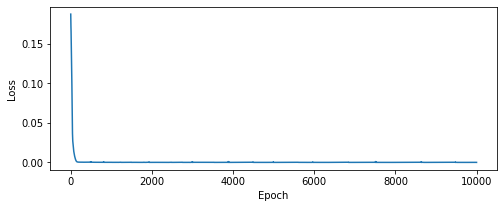

In [40]:
config = Config()

model = NN(config)
params = model.init(jax.random.PRNGKey(0), t_n, x_n)


def loss_fn(params, input_data, output_data):
    t, x = input_data
    u = output_data
    return data_driven_loss_fn(params, t, x, u)


init = time()
params, (loss_history, params_history) = fit(config, params, loss_fn, (t_n, x_n), u_n)
print(f"Training time: {time() - init:.2f} seconds")

plt.figure(figsize=(8, 3))
plt.plot(loss_history)
plt.xlabel("Epoch")
_ = plt.ylabel("Loss")


Let's see what the model has learned.

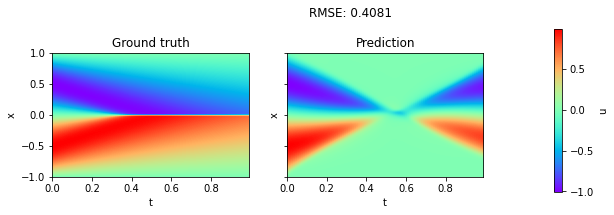

In [41]:
def plot(model, params):
    T, X = np.meshgrid(t_gt, x_gt)
    pred_u = predict(model, params, (T.reshape(-1, 1), X.reshape(-1, 1)))

    fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True, sharex=True)

    for ax, u, title in zip(
        axes, [u_gt, pred_u.reshape(T.shape).T], ["Ground truth", "Prediction"]
    ):
        img = ax.imshow(
            u.T,
            aspect="auto",
            cmap="rainbow",
            origin="lower",
            extent=[t_gt.min(), t_gt.max(), x_gt.min(), x_gt.max()],
        )
        ax.set_xlabel("t")
        ax.set_ylabel("x")
        ax.set_title(title)

    cb = fig.colorbar(img, ax=axes.ravel().tolist())
    cb.set_label("u")
    fig.suptitle(
        f"RMSE: {np.sqrt(np.mean((u_gt.ravel() - pred_u.reshape(T.shape).T.ravel())**2)):.4f}",
    )
    # adjust for colorbar in tight layout
    plt.tight_layout(rect=[0, 0, 0.7, 1])


plot(model, params)

We can see that the prediction is not very good. Let's now train it by including the physics-informed loss.

Training time: 30.09 seconds


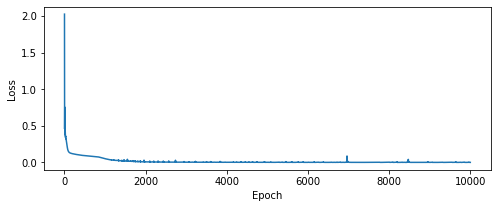

In [45]:
params = model.init(jax.random.PRNGKey(1), t_n, x_n)


def loss_fn(params, input_data, output_data):
    t_ic, x_ic, t_c, x_c = input_data
    u = output_data
    return data_driven_loss_fn(params, t_ic, x_ic, u) + physics_informed_loss_fn(
        params, t_c, x_c
    )


init = time()
params, (loss_history, params_history) = fit(
    config, params, loss_fn, (t_ic, x_ic, t_c, x_c), u_ic
)

print(f"Training time: {time() - init:.2f} seconds")

plt.figure(figsize=(8, 3))
plt.plot(loss_history)
plt.xlabel("Epoch")
_ = plt.ylabel("Loss")

Let's see what physics-informed model has learned.

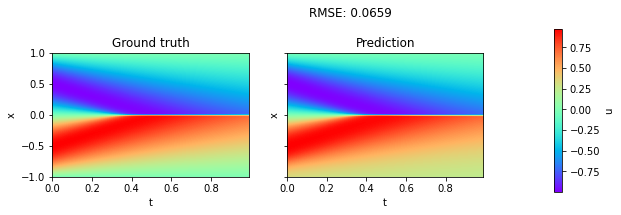

In [46]:
plot(model, params)

We can also compare the performance at a perticular time step.

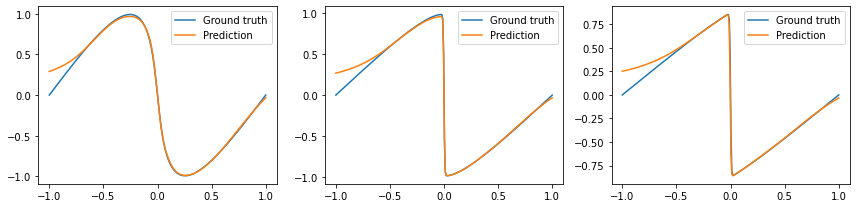

In [47]:
times = [0.25, 0.5, 0.75]
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
T, X = np.meshgrid(t_gt, x_gt)
df = pd.DataFrame(np.hstack([T.reshape(-1, 1), X.reshape(-1, 1), u_gt.T.reshape(-1, 1)]), columns=["t", "x", "u"])

for ax, timestep in zip(axes, times):
    idx = df["t"] == timestep
    t_t = df["t"][idx].values.reshape(-1, 1)
    x_t = df["x"][idx].values.reshape(-1, 1)
    u_t = df["u"][idx].values.reshape(-1, 1)
    pred_u = predict(model, params, (t_t, x_t))
    ax.plot(x_t, u_t, label="Ground truth")
    ax.plot(x_t, pred_u, label="Prediction")
    ax.legend()
fig.tight_layout();

## Discrete time PINNs

We generally use Runge-Kutta methods to simulate the evolution of a system over time in discrete time-steps. Let's start with some basics of Runge-Kutta methods.

### Runge-Kutta methods

Let's say we have a system that is governed by a PDE:
$$
\frac{\partial u}{\partial t} = f(u, t)
$$
where $u$ is a function of $t$ and $f$ is a function of $u$ and $t$. This equation says that rate of change in $u$ with respect to time is dependent on $u$ and $t$.

If we know the value of $u$ at time $t$, we can use the Runge-Kutta method to find the value of $u$ at a later time $t+\Delta t$. Here is how we can do it with Runge-Kutta 4th order method:
$$
u_{t+\Delta t} = u_t + \frac{1}{6}(k_1 + 2k_2 + 2k_3 + k_4)
$$
where

\begin{align}
k_1 &= f(u_t, t) \\
k_2 &= f(u_t + \Delta t \frac{k_1}{2}, t + \frac{\Delta t}{2}) \\
k_3 &= f(u_t + \Delta t \frac{k_2}{2}, t + \frac{\Delta t}{2}) \\
k_4 &= f(u_t + \Delta t k_3, t + \Delta t)
\end{align}

We can generelize the above equation for any order of Runge-Kutta method as follows:
$$
u_{t+\Delta t} = u_t + \Delta t \sum_{i=1}^{s} b_i k_i
$$
where $s$ is the order of the Runge-Kutta method and $b_i$ are the coefficients of the method. The intermediate values $k_i$ are given by:
$$
k_i = f\left(u_t + \Delta t \sum_{j=1}^{s} a_{ij} k_j, t + c_i \Delta t\right)
$$
where $a_{ij}$ are the coefficients of the method and $c_i$ are the nodes of the method.

Values of $a_{ij}$, $b_i$ and $c_i$ are tabulated for different orders of Runge-Kutta methods known as Butcher tableau. Here is the Butcher tableau for Runge-Kutta 4th order method:

| $c_i$ | $a_{ij}$ | $b_i$ |
|-------|----------|-------|
| 0     |          | 1/6   |
| 1/2   | 1/2      | 1/3   |
| 1/2   | 0        | 1/3   |
| 1     | 0        | 1/6   |